# About
This notebook implements an AI-agent workflow that enables evaluation of any set of items using a group of customized personas and criteria. In the workflow, each persona is prompted to rate the given items under the defined criteria using a score from 1 to 5. After rating, they also provide a personal ordering of the items.

The overall workflow proceeds as follows:

1. **Prompt setup**
    1. Define the evaluation subject and items
    2. Create persona definitions and evaluation criteria
    3. Set up a prompt template for the personas
2. **Generate evaluations**
    1. For each persona, apply the prompt template and make an API call
    2. Parse and store the returned evaluations
3. **Process evaluations**
    1. Normalize the results
    2. Apply weights to each persona or criterion (if applicable)
4. **Display the results**

# Instructions


---


Follow the steps below to set up and use this notebook properly. These instructions will help ensure everything works smoothly, especially if you're using Google Colab for the first time.


## I. Save a Copy to Your Own Google Drive


---


To make changes to this notebook and save your progress, you need to create your own editable copy.
Click `Copy to Drive` on top to do so  
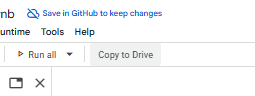  

## II. Get a Google API key


---


> *Skip this step if you already have a valid API key created in Google AI Studio.*

To use Gemini in this notebook, you'll need to get an API key from Google AI Studio.

1. On the left side panel of this notebook, click the `Secrets` secrets.png tab.
2. Find and click on Gemini API keys, then select Manage API keys in Google AI Studio.  
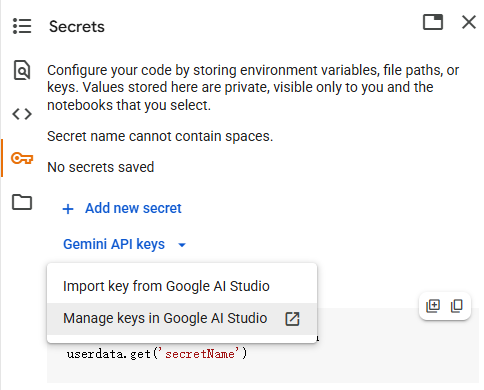  
This will open a new browser tab directing you to Google AI Studio.
3. In the new tab, login to Google AI Studio and click 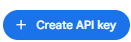 to create an API key
4. Select the default Google Cloud project and click `Create API key in existing project`
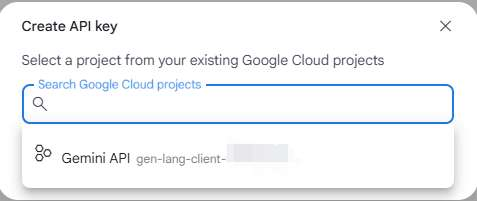
> *If there's no existing project, use the "create api key in a new project" button*

## III. Add Google API Key to secrets


---



> *If a Google API key already exists in Secrets, simply enable it and skip this part.*

Once you have your API key from Google AI Studio, you'll need to import it into this notebook:

1. Navigate to the `Secrets` secrets.png tab on left
2. Under `Gemini API keys`, click `Import key from Google AI Studio`.
3. Import the key you just created

## IV. Run the notebook


---


Now you' re ready to run the code and interact with the notebook.
- Every code cell in this notebook has a **run button** image.png that appears in the top-left corner when you hover your mouse over the cell. Click on this button to run the cell.
- Alternatively, you can select the cell and press `Shift` + `Enter` to run it.
- The outputs of the cells will be displayed below it.
- You can use the `Table of contents` tab image.png on the left sidebar to jump between sections easily.
- Variables that can be modified are marked with `# CHANGE ME`. Read the code comments to understand how and why you might want to adjust that variable.
- Keep in mind that **cells are interdependent**. In most cases:
  - You must run all previous cells at least once before running the next one.
  - Skipping earlier cells may cause later cells to fail or behave unexpectedly.
- If you change the contents of a cell, **you need to re-run that cell** for the update to take effect.
- **After updating a variable in one cell, you must re-run any other cells that depend on that variable** for the changes to be reflected in their output.

# Environment setup
This part sets up the running environment of this notebook, which includes
- Installing and importing the dependencies
- Defines utils used in this notebook
- Setting up the LLM

In [ ]:
# Install dependencies
!pip install -q -r https://raw.githubusercontent.com/AI-Agents-Prompts-to-Multi-Agent-Sys/Quantitative-Eval/master/requirements.txt

In [ ]:
# Import libraries
import os
import json
import operator
import re
from copy import deepcopy
from typing import TypedDict, Annotated, List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.constants import END, START
from langgraph.graph import StateGraph
from tqdm import tqdm
from tenacity import retry, stop_after_attempt

def clean_json_string(text: str) -> str:
  """
  Cleans the markdowns around a json response
  """
  cleaned = re.sub(r"```(?:json)?", "", text)
  return cleaned.replace("```", "").strip()

# Load environment variables (GOOGLE_API_KEY should be set either in .env file or in the secrets)
try:
    from google.colab import userdata
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
except ImportError:
    from dotenv import load_dotenv
    load_dotenv()

# LLM config
# At here you can change the model, tweak its parameters, or even use different LLM provider
# Options for Gemini models include:
# - "gemini-2.5-flash"
# - "gemini-2.5-pro"
# replace the string after model= with the model you want to use
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)

If this cell above throws out an error, please check if
- `GOOGLE_API_KEY` is set and **it's name matches exactly**
- Access to `GOOGLE_API_KEY` is granted

You could also read the error message for more details

# Prompt setup
This part sets up the prompt template for the personas, which includes the following steps:
- Set up the evaluation subject and items
- Set up the personas and criteria
- Establish the prompt template

First, set up the evaluation subject

In [ ]:
# What to evaluate
EVALUATION_SUBJECT = "band" # CHANGE ME

Then, set up items to evaluate

In [ ]:
# CHANGE ME
# List of items to evaluate
ITEMS = ['The Beatles',
         'Queen',
         'The Rolling Stones',
         'Led Zeppelin',
         'Pink Floyd',
         'U2',
         'AC/DC',
         'Metallica',
         "Guns N' Roses",
         'Nirvana']

Next, initialize the personas and the evaluation criteria.

In [ ]:
# Initialize personas and criteria manually

# CHANGE ME
# Persona definitions
# Each persona has generates a call to the LLM, so please be aware of the rate limits of your LLM provider
# For Gemini, the rate limit is 10 calls per minute for 2.5 flash models and 5 calls per minute for 2.5 pro models.
# For Gemini rate limit details, visit https://ai.google.dev/gemini-api/docs/rate-limits
PERSONAS = {
    "metalhead": "You're in your 30s, a lifelong metal fan. You value power, aggression, instrumental mastery, and complexity. You dismiss pop and overproduced music as shallow.",
    "popstar": "You're in your 20s, immersed in social media culture. You love global accessibility, emotional resonance, and catchy choruses. You believe great bands bring joy and unity.",
    "boomer": "You're in your 70s. You grew up during the golden age of rock and believe greatness is rooted in legacy, songwriting, and timeless appeal. Newer music feels synthetic to you.",
    "genz": "You're a teenager, online-native, and value diversity, identity, and innovation in music. You're drawn to bands that say something real or break genre rules.",
    "indie": "You're in your 30s, an art-school type who craves authenticity, emotion, and underground cool. You dislike commercial polish and love expressive weirdness.",
}

# CHANGE ME
# Criteria for evaluation
CRITERIA = {
    "Musical Innovation": "Pioneering ideas, new sounds, genre blending.",
    "Cultural Impact": "Broader societal influence, pop culture penetration.",
    "Lyrical or Thematic Depth": "Narrative richness, philosophical weight, relatability.",
    "Technical Proficiency": "Musical complexity, virtuosity, performance execution.",
    "Live Performance Strength": "Energy, presence, crowd connection on stage.",
    "Legacy & Longevity": "Enduring influence across generations and artists."
}

# CHANGE ME
# Instructions/background information for the personas
PERSONA_ROLE = "music critic"
# CHANGE ME
INSTRUCTION = f"You have been asked to evaluate the greatness of {len(ITEMS)} historically significant bands."

Establish the template and print the test prompt.

This cell creates the make prompt function, which takes a persona description and applies the template and the template variables we set before. This cell will output the template for the first persona as an example.


In [ ]:
# CHANGE ME...?
# Yes, you could change the prompt template for the personas, but it probably won't make much difference and might break the code
# If really want to change this, make sure not to modifiy the format of the outputed JSON.
def make_prompt(persona_description):
    return f"""You are a {PERSONA_ROLE} with the following worldview:

{persona_description}

{INSTRUCTION}

Evaluate each {EVALUATION_SUBJECT} based on the following {len(CRITERIA)} criteria, scoring from 1 (low) to 5 (high):

{"".join(f"{key}: {value}{chr(10)}" for key, value in CRITERIA.items())}
Here are the {EVALUATION_SUBJECT}s to evaluate:
{chr(10).join('- ' + item for item in ITEMS)}

Please respond ONLY in the following strict JSON format:

```json
{{
  "ratings": [
    {{
      "item": "the corresponding {EVALUATION_SUBJECT} name here, following the ordering in the given list"{"".join(f',{chr(10)}      "{criteria}": int' for criteria in CRITERIA)}
    }},
    // ...More {EVALUATION_SUBJECT} evaluations here
  ],
  "justification": "Your paragraph explaining the ratings here.",
  "ranking": ["{EVALUATION_SUBJECT}1", "{EVALUATION_SUBJECT}2", ..., "{EVALUATION_SUBJECT}{len(ITEMS)}"]
}}
```

- The ratings list must include all {len(ITEMS)} {EVALUATION_SUBJECT}s.
- The ranking list must be in your personal order (1st to {len(ITEMS)}th).
- Do not include any commentary outside the JSON block.
"""

print("Example prompt:")
print(make_prompt(list(PERSONAS.values())[0]))

# Generate Evaluations
This part performs the API calls, parses the responses, and stores them. This process takes around 40s

The output displays the scores of items under each criterion by persona(higher is better). The last column named `rank` is the ordering of items given by the persona(1 is the best).

In [ ]:
print("Starting evaluation...")

# Parse JSON
def parse_json_response(response):
    response_cleaned = clean_json_string(response)
    data = json.loads(response_cleaned)
    ratings = data["ratings"]
    justification = data["justification"]
    ranking = data["ranking"]

    ranking_column = []
    for i, item in enumerate(ranking):
        ranking_column += [{"item": item, "rank": i + 1}]

    df = pd.DataFrame(ratings)

    df = pd.merge(df, pd.DataFrame(ranking_column), on="item", how="left")
    df.columns = [EVALUATION_SUBJECT[0].upper() + EVALUATION_SUBJECT[1:]] + list(CRITERIA.keys()) + ["Rank"]
    return df, justification

# Get llm response
@retry(stop=stop_after_attempt(3))
async def get_llm_response(prompt):
    response = await llm.ainvoke(prompt)
    return parse_json_response(response.content)

# State definition
class Vote(TypedDict):
    df: pd.DataFrame
    justification: str
    persona: str

class State(TypedDict):
    votes: Annotated[List[Vote], operator.add]

# Initialize progress bar
try:
    pbar.close()
except NameError:
    pass

pbar = tqdm(f"Evaluating {EVALUATION_SUBJECT}s with personas", total=len(PERSONAS), unit="persona")

# Agent node
def make_agent_node(persona_key):
    async def node(state):
        persona = PERSONAS[persona_key]
        prompt = make_prompt(persona)
        df, justification = await get_llm_response(prompt)

        state['votes'] = [{
                "df": df,
                "justification": justification,
                "persona": persona_key,
        }]

        pbar.update(1)
        return state
    return node

# Graph build
agent_keys = list(PERSONAS.keys())

graph = StateGraph(State)
for agent in agent_keys:
    graph.add_node(agent, make_agent_node(agent))

# Graph edges
for agent in agent_keys:
    graph.add_edge(START, agent)
graph.add_edge([agent for agent in agent_keys], END)

# Run
compiled = graph.compile()
results = await compiled.ainvoke({
    "votes": [],
})

votes = results['votes']
criteria_keys = list(CRITERIA.keys())

# Display results
for vote in votes:
    print(f"\n ================== Evaluation by persona: {vote['persona']} ==================")
    display(vote['df'])

# Process Evaluations

## Optional: Normalize the scores
This step reduces the bias from individual scoring tendencies by calculating the z-score of the scores by persona. It then shifts the score so that we don't have negative scores

In [ ]:
# Normalize the scores
for vote in votes:
    all_values = vote['df'][criteria_keys].values.flatten()
    mean = all_values.mean()
    std_dev = all_values.std()
    vote['df'][criteria_keys] = (vote['df'][criteria_keys] - mean) / std_dev

# Ensure all scores are non-negative
min_z = min([vote['df'][criteria_keys].min().min() for vote in votes])
for vote in votes:
    vote['df'][criteria_keys] = vote['df'][criteria_keys] - min_z

# Display normalized scores
for vote in votes:
    print(f"================== Normalized scores for persona: {vote['persona']} ==================")
    display(vote['df'])

## Set the weight for each criterion

Here you can change the weight for each criterion to reflect its importance in the overall evaluation.

A higher weight means the criterion will have a greater impact on the final score, giving more influence to items that perform well in that area.

The scores after this cell would refer to the weighted score.

> Please note that the size and order of the weights array must match the number of criteria defined in the `CRITERIA` dictionary.

The following cell prints out your criteria for reference

In [ ]:
pd.DataFrame(criteria_keys).T

Change the `weights` variable to change the weights

In [ ]:
# weights for each criterion
# The length and order of this list MUST MATCH the criteria
weights = [1, 1, 1, 1, 1, 1] # CHANGE ME

weighted_votes = [ deepcopy(vote) for vote in votes ]

for weighted_vote, vote in zip(weighted_votes, votes):
    for i, key in enumerate(criteria_keys):
        weighted_vote['df'][key] = vote['df'][key] * weights[i]
    weighted_vote['df']['score_sum'] = weighted_vote['df'][criteria_keys].sum(axis=1)

# Display weighted scores
for weighted_vote in weighted_votes:
    print(f"================== Weighted scores for persona: {weighted_vote['persona']} ==================")
    display(weighted_vote['df'])

## Calculate the final scores
Sum up the scores for each item across all personas, and then display the final scores.

This table displays the score summary. You could click the 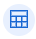 on the top right of the table to convert it to an interactive table and then click on the columns to sort by a different criterion.

In [ ]:
final_scores = weighted_votes[0]['df'].copy().drop(columns=['score_sum'])
for vote in weighted_votes[1:]:
    final_scores[criteria_keys] += vote['df'][criteria_keys]

final_scores = final_scores.drop(columns=['Rank'])
final_scores['total score'] = final_scores[criteria_keys].sum(axis=1)
# Sort by total score
final_scores = final_scores.sort_values(by='total score', ascending=False)

final_scores = final_scores.set_index(EVALUATION_SUBJECT[0].upper() + EVALUATION_SUBJECT[1:])

final_scores

# Visualization

## Score Breakdown
This chart shows each item's total score and how that score is split among the criteria. Each bar is an item, and its length is the total score. The colored parts show the score for each criterion. This helps you see the total score and which criteria contributed the most. Items are ordered by total score from highest to lowest.

In [ ]:
final_scores['total score'] = final_scores[criteria_keys].sum(axis=1)
final_scores = final_scores.sort_values(by='total score', ascending=True)
final_scores = final_scores.drop(columns=['total score'])
final_scores.plot(kind='barh', stacked=True, figsize=(12, 7), colormap='tab20c')
plt.title("Score Breakdown")
plt.xlabel("Total Score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Radar Chart

The radar charts show how each item scores on different criteria. Each axis stands for a criterion, and the point along that axis shows the score—the farther from the center, the higher the score.

For example, a wide, balanced shape that stretches far in all directions means the item scores well across the board. A narrow or uneven shape might show strong performance in some areas but weaknesses in others.

In [ ]:
items = final_scores.mean(axis=1).sort_values(ascending=False).index

for item in items:
    values = final_scores.loc[item, criteria_keys].values.flatten().tolist()
    values += values[:1]

    angles = np.linspace(0, 2 * np.pi, len(criteria_keys), endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=2, label=item)
    ax.fill(angles, values, alpha=0.3)
    ax.set_thetagrids(np.degrees(angles[:-1]), criteria_keys)
    ax.set_title(f"{item} Score Profile")
    plt.show()

## Heatmap of Criteria Correlation

This heatmap shows how the different evaluation criteria are related to each other. The colors indicate the strength of the relationship:

- Red/warm colors mean that if an item scores high on one criterion, they are likely to score high on the other related criterion as well.
- Blue/cool colors mean that if an item scores high on one criterion, they are likely to score low on the other, or vice versa.
- Colors near the middle mean there's not much of a relationship between the two criteria.

This helps you understand if the criteria are measuring similar things or if they are independent aspects of evaluation.

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(final_scores[criteria_keys].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Evaluation Criteria")
plt.show()

## Heatmap of individual rankings

This heatmap shows the ranking given by each persona to each item.

> Note that rankings are independent of the scores, and a lower number is better (1 means first place).

The columns are sorted so that the item with the best average ranking (lowest number) are on the left. Each row represents a persona, and the color and number in each cell show you where that persona ranked each item. It visually highlights which items were consistently ranked high or low across the different personas, and where there were disagreements in ranking.

In [ ]:
rank_matrix = []
items = weighted_votes[0]['df'][EVALUATION_SUBJECT[0].upper() + EVALUATION_SUBJECT[1:]].tolist()
for weighted_vote in weighted_votes:
    rank_row = dict(zip(weighted_vote['df'][EVALUATION_SUBJECT[0].upper() + EVALUATION_SUBJECT[1:]], list(weighted_vote['df']['Rank'])))
    rank_matrix.append(rank_row)

rank_df = pd.DataFrame(rank_matrix, index=[i['persona'] for i in weighted_votes], columns=items)
rank_df = rank_df.loc[:, rank_df.mean().sort_values().index]
plt.figure(figsize=(14, 6))
sns.heatmap(rank_df, cmap="coolwarm", annot=True, fmt="d", cbar_kws={"label": "Rank (lower is better)"})
plt.title(f"{EVALUATION_SUBJECT[0].upper() + EVALUATION_SUBJECT[1:]} Rankings by Persona")
plt.xlabel(EVALUATION_SUBJECT[0].upper() + EVALUATION_SUBJECT[1:])
plt.ylabel("Persona")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Statistics

## Summary on rankings

This table displays the statistics on ranking. You could click the 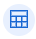 on the top right of the table to convert it to an interactive table and then click on the columns to sort by a different statistic.


By default, it's sorted by standard deviation, which reflects the level of disagreement among opinions.

Other sorting options are:
- `mand_rank`: The average rank of the item
- `max_rank` / `min_rank`: The maximum/minimum rank of the item

> Remember that rank is independent of the scoring and not affected by weights. A lower number is better (1 means first place).

In [ ]:
item_ranks = {item: [] for item in ITEMS}
for vote in weighted_votes:
    for item, rank in zip(vote['df'][EVALUATION_SUBJECT[0].upper() + EVALUATION_SUBJECT[1:]], vote['df']['Rank']):
        item_ranks[item].append(rank)

stats = {
    item: {
        "mean_rank": np.mean(ranks),
        "std_dev": np.std(ranks),
        "min_rank": min(ranks),
        "max_rank": max(ranks)
    }
    for item, ranks in item_ranks.items()
}

rank_stats_df = pd.DataFrame(stats).T.sort_values("std_dev", ascending=False)
rank_stats_df


## Summary on scores

This table displays the statistics on the accumulated score by item by criterion. You could click the 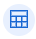 on the top right of the table to convert it to an interactive table and then click on the columns to sort by a different statistic.


By default, it's sorted by standard deviation, which reflects the level of disagreement among opinions.

Other sorting options are:
- `mand_score`: The average score on that criterion of that item
- `max_score` / `min_score`: The maximum/minimum score on that criterion of that item

In [ ]:
item_scores = {f'{item}: {criteria}': [] for item in ITEMS for criteria in criteria_keys}
for vote in weighted_votes:
    for criteria in criteria_keys:
        for item, score in zip(vote['df'][EVALUATION_SUBJECT[0].upper() + EVALUATION_SUBJECT[1:]], vote['df'][criteria]):
            item_scores[f'{item}: {criteria}'].append(score)

stats = {
    item: {
        "mean_score": np.mean(ranks),
        "std_dev": np.std(ranks),
        "min_score": min(ranks),
        "max_score": max(ranks)
    }
    for item, ranks in item_scores.items()
}

score_stats_df = pd.DataFrame(stats).T.sort_values("std_dev", ascending=False)
score_stats_df

# More analyzations

Now you can create new analytics with Gemini! Click on 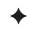 on the bottom middle of the page, and ask Gemini to create any analytics you want！